## Pneumonia_classification


### The dataset comprising of 3827 chest x-ray image of pneumonia and 1532 chest x-ray image of normal.
### Our required task is to classify pneumonia condition and normal condition.
### Our evaluvation metrics would be AUC-ROC Score, Precison, Recall as it is for medical purpose our focus is to look on  true postitive rate, false postitive rate rather than looking on accuracy.


### Importing the required libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dense, Flatten,BatchNormalization,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report,log_loss
from keras.initializers import RandomNormal,GlorotNormal
import matplotlib.pyplot as plt
import glob
import random
import os
import seaborn as sns

In [ ]:
## Location of ct-xray image dataset

train_path = r'../input/chest-xray-pneumonia/chest_xray/train'
test_path = r'../input/chest-xray-pneumonia/chest_xray/test'
val_path = r'../input/chest-xray-pneumonia/chest_xray/val'

In [ ]:
## reading the image and resizing all the image to a standard size

image_size=[224,224]

datagen = ImageDataGenerator(rescale = 1/255, samplewise_std_normalization = True,
                            samplewise_center = True)

train_batch = datagen.flow_from_directory(directory=train_path
                                          ,batch_size = 250,target_size=image_size,shuffle =True, seed=0,
                                          classes=['NORMAL','PNEUMONIA'])

test_batch = datagen.flow_from_directory(directory=test_path
                                          ,batch_size =16,target_size=image_size,shuffle =False
                                          ,classes=['NORMAL','PNEUMONIA'])

val_batch = datagen.flow_from_directory(directory=val_path
                                          ,batch_size = 179,target_size=image_size,shuffle =True
                                          ,classes=['NORMAL','PNEUMONIA'])
train_batch.class_indices

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

,Status,Img_name
0,NORMAL,IM-0242-0001.jpeg
1,NORMAL,NORMAL2-IM-1047-0001.jpeg
2,NORMAL,NORMAL2-IM-0553-0001.jpeg
3,NORMAL,NORMAL2-IM-0578-0001.jpeg
4,NORMAL,NORMAL2-IM-0945-0001.jpeg


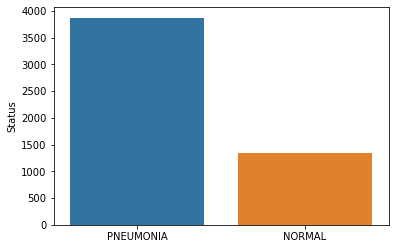

In [ ]:
## compiling the image and their target variables in a dataframe 

nor_path = r'../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
pneu_path = r'../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'

label = ['NORMAL','PNEUMONIA']

files = [[j,k] for j in label for k in 
         os.listdir(os.path.join(r'../input/chest-xray-pneumonia/chest_xray/train',j))]
df = pd.DataFrame(files,columns=['Status','Img_name'])

sns.barplot(df.Status.value_counts().index,df.Status.value_counts())
df.head()

##### It is clearly seen that the dataset is imbalanced 

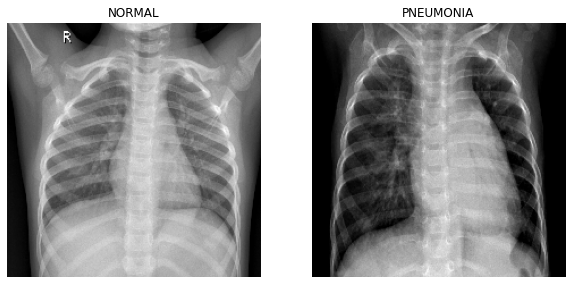

In [ ]:
## sample image of Pneumonia and normal ones

nor_img = load_img(os.path.join(nor_path, df[df.Status == 'NORMAL'].Img_name[0])
                   ,target_size=(224,224))
pne_img = load_img(os.path.join(pneu_path, df[df.Status == 'PNEUMONIA'].Img_name.iloc[2]),
                   target_size=(224,224))

def img_(nor_img,pne_img):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.title('NORMAL')
    plt.imshow(nor_img)
    plt.axis('off')

    plt.subplot(122)
    plt.title('PNEUMONIA')
    plt.imshow(pne_img)
    plt.axis('off')
img_(nor_img,pne_img)

In [ ]:
def result_plot(train_accuracy, val_accuracy,train_loss,val_loss):
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.plot(train_accuracy) , plt.plot(val_accuracy)
    plt.xlabel('No.of Epoch'),plt.ylabel('Accuracy'),plt.legend(['train_accuracy','val_accuracy'],
                                                          bbox_to_anchor=(.575,.575,.575,.575))
    plt.ylim(0,1.2)
    
    plt.subplot(122)
    plt.plot(train_loss) , plt.plot(val_loss)
    plt.xlabel('No. of Epoch'),plt.ylabel('loss'),plt.legend(['train_loss','val_loss'],
                                                          bbox_to_anchor=(.575,.575,.575,.575))
    plt.ylim(0,max(max(val_loss),max(train_loss)))
    

In [ ]:
## Baseline model to benchmark the performance of the Deep neural networks

model_baseline = Sequential([Conv2D(filters = 16 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3),activation='relu', padding = 'valid',input_shape = (224,224,3)),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                   Flatten(),
                   Dense(units = 2,activation = 'softmax')])

model_baseline.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])   

model_baseline.summary()

r = model_baseline.fit_generator(train_batch,
  validation_data=(val_batch),
  epochs=1,
  steps_per_epoch=len(train_batch),
  verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 197136)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 394274    
Total params: 394,722
Trainable params: 394,722
Non-trainable params: 0
_________________________________________________________________
21/21 [==============================] - 69s 3s/step - loss: 1.8605 - accuracy: 0.6869 - val_loss: 0.8197 - val_accuracy: 0.6250


In [ ]:
pred = model_baseline.predict(test_batch)
pred_class = model_baseline.predict_classes(test_batch)

#### For this problem we choose F1 score, Precision, recall as the evaluvation metrics as our focus to capture the TPR, FPR

              precision    recall  f1-score   support

           0       0.91      0.43      0.58       234
           1       0.74      0.97      0.84       390

    accuracy                           0.77       624
   macro avg       0.82      0.70      0.71       624
weighted avg       0.80      0.77      0.74       624



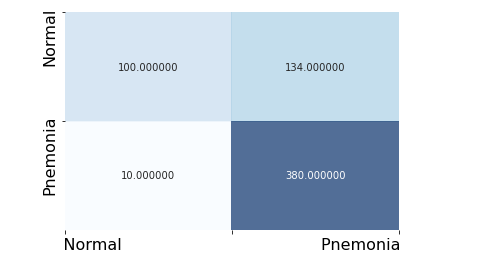

In [ ]:
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(np.arange(2),['Normal','Pnemonia' ],
           fontsize=16,rotation=90)
print(classification_report(test_batch.classes,pred_class))

In [ ]:
##  First Deep neural network with RMSprop as an optimizer

model = Sequential([Conv2D(filters = 16 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3),activation='relu', padding = 'same',input_shape = (224,224,3)),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                   Conv2D(filters = 32 ,kernel_initializer=tf.initializers.GlorotNormal,
                          kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2),strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 64 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 128 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 256 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 256 ,kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(units = 512,activation = 'relu'),
                    Dense(units = 2,activation = 'softmax')])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', patience=5, 
        verbose=1, mode='min', restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)      

In [ ]:
r = model.fit_generator(train_batch,
  validation_data=val_batch,
  epochs=100,
  steps_per_epoch=len(train_batch),
  validation_steps=len(test_batch),
  callbacks=[monitor] )

Epoch 1/100
21/21 [==============================] - 54s 3s/step - loss: 3.2027 - accuracy: 0.8025 - val_loss: 0.6695 - val_accuracy: 0.6250
Epoch 2/100
21/21 [==============================] - 54s 3s/step - loss: 0.2412 - accuracy: 0.8951 - val_loss: 0.6443 - val_accuracy: 0.6875
Epoch 3/100
21/21 [==============================] - 54s 3s/step - loss: 0.2371 - accuracy: 0.9172 - val_loss: 0.6432 - val_accuracy: 0.5625
Epoch 4/100
21/21 [==============================] - 54s 3s/step - loss: 0.1654 - accuracy: 0.9339 - val_loss: 0.6376 - val_accuracy: 0.8125
Epoch 5/100
21/21 [==============================] - 53s 3s/step - loss: 0.1965 - accuracy: 0.9277 - val_loss: 0.6313 - val_accuracy: 0.8125
Epoch 6/100
21/21 [==============================] - 54s 3s/step - loss: 0.1035 - accuracy: 0.9630 - val_loss: 0.6228 - val_accuracy: 0.7500
Epoch 7/100
21/21 [==============================] - 55s 3s/step - loss: 0.1628 - accuracy: 0.9530 - val_loss: 0.5979 - val_accuracy: 0.7500
Epoch 8/100
2

In [ ]:
pred = model.predict(test_batch)
pred_class = model.predict_classes(test_batch)

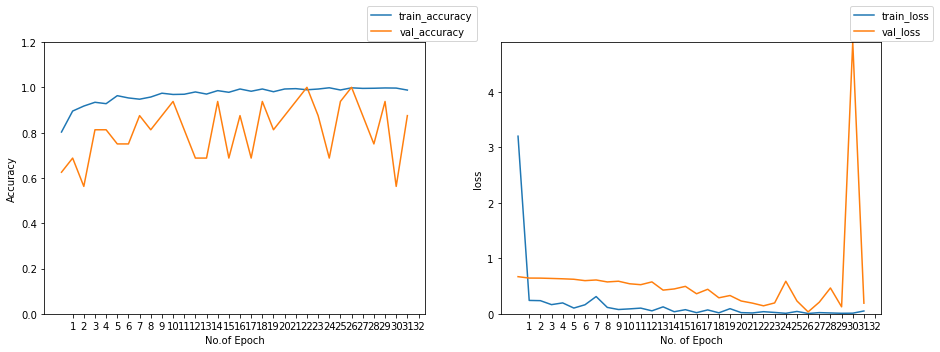

In [ ]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

              precision    recall  f1-score   support

           0       0.95      0.49      0.64       234
           1       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



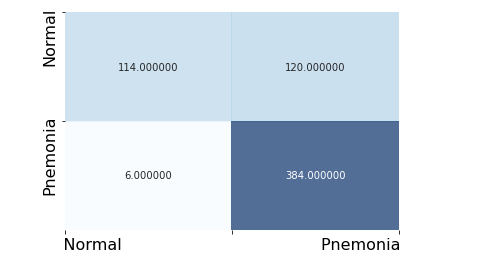

In [ ]:
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(np.arange(2),['Normal','Pnemonia' ],
           fontsize=16,rotation=90)
print(classification_report(test_batch.classes,pred_class))


0.735897435897436


Text(0, 0.5, 'TPR')

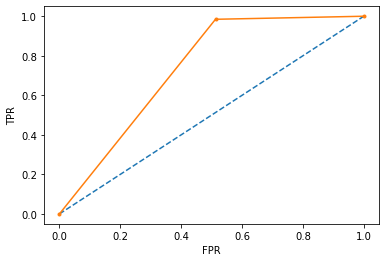

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve

fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print(auc_score)

ns_probs = [0 for _ in range(len(test_batch.labels))]
ns_auc = roc_auc_score(test_batch.labels, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(test_batch.labels, ns_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CNN')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
model_adams = Sequential([Conv2D(filters = 16 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3),activation='relu', padding = 'same',input_shape = (224,224,3)),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                          BatchNormalization(),
                   Conv2D(filters = 32 ,kernel_initializer=tf.initializers.GlorotNormal,
                          kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2),strides = 2),
                          BatchNormalization(),
                    Conv2D(filters = 64 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                          BatchNormalization(),
                    Conv2D(filters = 128 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 256 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(units = 512,activation = 'relu'),
                    Dense(units = 2,activation = 'softmax')])

model_adams.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', patience=5, 
        verbose=1, mode='min', restore_best_weights=True)

In [ ]:
r = model_adams.fit_generator(train_batch,
  validation_data=val_batch,
  epochs=100,
  steps_per_epoch=len(train_batch),
  validation_steps=len(test_batch),
  callbacks=[monitor] )

Epoch 1/100
21/21 [==============================] - 55s 3s/step - loss: 1.1434 - accuracy: 0.7816 - val_loss: 0.6877 - val_accuracy: 0.8125
Epoch 2/100
21/21 [==============================] - 55s 3s/step - loss: 0.1818 - accuracy: 0.9231 - val_loss: 0.6659 - val_accuracy: 0.5625
Epoch 3/100
21/21 [==============================] - 53s 3s/step - loss: 0.0915 - accuracy: 0.9632 - val_loss: 0.6560 - val_accuracy: 0.5625
Epoch 4/100
21/21 [==============================] - 54s 3s/step - loss: 0.0724 - accuracy: 0.9718 - val_loss: 0.6276 - val_accuracy: 0.8125
Epoch 5/100
21/21 [==============================] - 54s 3s/step - loss: 0.0627 - accuracy: 0.9766 - val_loss: 0.6364 - val_accuracy: 0.7500
Epoch 6/100
21/21 [==============================] - 53s 3s/step - loss: 0.0537 - accuracy: 0.9780 - val_loss: 0.6089 - val_accuracy: 0.8750
Epoch 7/100
21/21 [==============================] - 54s 3s/step - loss: 0.0475 - accuracy: 0.9818 - val_loss: 0.5790 - val_accuracy: 0.8750
Epoch 8/100
2

In [ ]:
pred = model_adams.predict(test_batch)
pred_class = model_adams.predict_classes(test_batch)

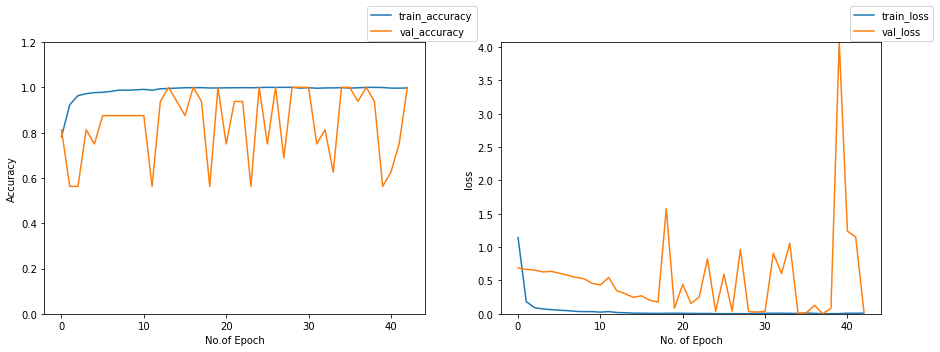

In [ ]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

              precision    recall  f1-score   support

           0       0.97      0.50      0.66       234
           1       0.77      0.99      0.86       390

    accuracy                           0.81       624
   macro avg       0.87      0.74      0.76       624
weighted avg       0.84      0.81      0.79       624



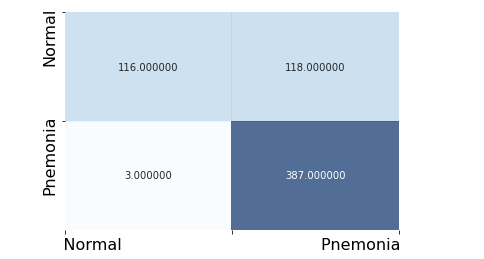

In [ ]:
## Confusion matrix
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(np.arange(2),['Normal','Pnemonia' ],
           fontsize=16,rotation=90)
print(classification_report(test_batch.classes,pred_class))

0.735897435897436


Text(0, 0.5, 'TPR')

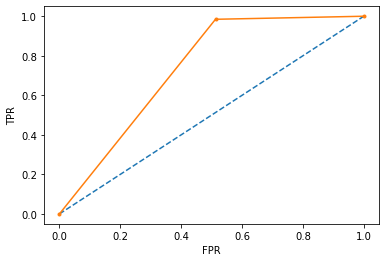

In [ ]:
##plotting the auc_roc curve
fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print(auc_score)

ns_probs = [0 for _ in range(len(test_batch.labels))]
ns_auc = roc_auc_score(test_batch.labels, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(test_batch.labels, ns_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CNN')
plt.xlabel('FPR')
plt.ylabel('TPR')

#### Now we Deploy the transfer learning techinique
#### 1. VGG_16 Model

In [ ]:
vgg16 = tf.keras.applications.vgg16.VGG16(input_shape = image_size+[3]
                                                ,weights='imagenet'
                                                ,include_top=False)

In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model_vgg = Sequential()

for layer in vgg16.layers:
    layer.trainable =False
    model_vgg.add(layer)
    
model_vgg.add(Flatten())
model_vgg.add(Dense(units = 2,activation = 'softmax'))
model_vgg.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
model_vgg.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy'
              , metrics=['accuracy'])

r_vgg = model_vgg.fit(train_batch,
  validation_data=val_batch,
  epochs=100,
  steps_per_epoch=len(train_batch),
  validation_steps=len(val_batch),
            callbacks=[monitor] )

Epoch 1/100
21/21 [==============================] - 57s 3s/step - loss: 0.3042 - accuracy: 0.8886 - val_loss: 0.5651 - val_accuracy: 0.7500
Epoch 2/100
21/21 [==============================] - 57s 3s/step - loss: 0.0868 - accuracy: 0.9682 - val_loss: 0.1649 - val_accuracy: 0.9375
Epoch 3/100
21/21 [==============================] - 57s 3s/step - loss: 0.0489 - accuracy: 0.9826 - val_loss: 0.1161 - val_accuracy: 1.0000
Epoch 4/100
21/21 [==============================] - 56s 3s/step - loss: 0.0348 - accuracy: 0.9898 - val_loss: 0.0656 - val_accuracy: 1.0000
Epoch 5/100
21/21 [==============================] - 57s 3s/step - loss: 0.0277 - accuracy: 0.9941 - val_loss: 0.0931 - val_accuracy: 1.0000
Epoch 6/100
21/21 [==============================] - 56s 3s/step - loss: 0.0234 - accuracy: 0.9956 - val_loss: 0.0718 - val_accuracy: 1.0000
Epoch 7/100
21/21 [==============================] - 62s 3s/step - loss: 0.0201 - accuracy: 0.9967 - val_loss: 0.0866 - val_accuracy: 1.0000
Epoch 8/100
2

In [ ]:
pred = model_vgg.predict(test_batch)
pred_class = model_vgg.predict_classes(test_batch)

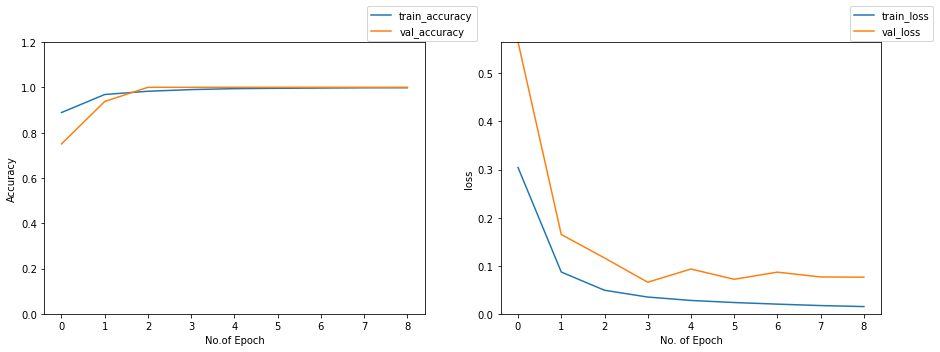

In [ ]:
train_loss = r_vgg.history['loss']
val_loss = r_vgg.history['val_loss']
train_accuracy = r_vgg.history['accuracy']
val_accuracy = r_vgg.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

AUC Score: 0.7538461538461538
              precision    recall  f1-score   support

           0       0.98      0.51      0.67       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



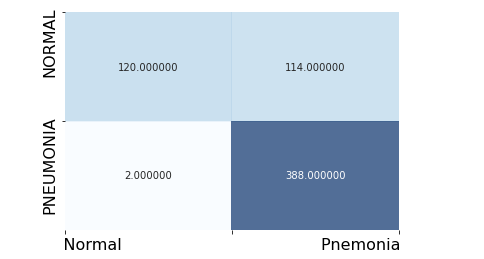

In [ ]:
fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print("AUC Score:",auc_score)


plt.figure()
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(range(2),label,fontsize= 16)
print(classification_report(test_batch.classes,pred_class))


0.6534188034188034


Text(0, 0.5, 'TPR')

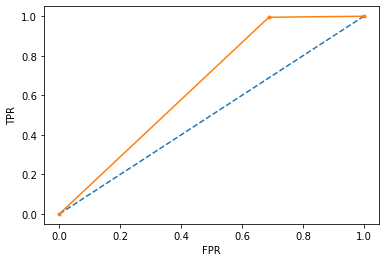

In [ ]:
fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print(auc_score)

ns_probs = [0 for _ in range(len(test_batch.labels))]
ns_auc = roc_auc_score(test_batch.labels, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(test_batch.labels, ns_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CNN')
plt.xlabel('FPR')
plt.ylabel('TPR')

#### 2. ResNet

In [ ]:
resnet = tf.keras.applications.ResNet50(input_shape = image_size+[3],
                                        weights='imagenet',
                                        include_top=False)
resnet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
for layer in resnet.layers:
    layer.trainable = False
x = Flatten()(resnet.output)
fc = Dense(units = 512,activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.0002))(dropout)
fc1 = Dense(units = 1028,activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.0002))(dropout1)
output = Dense(units = 2 , activation ='softmax')(fc1)

model_res = Model(inputs=resnet.input , outputs= output)

model_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model_res.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy'
              , metrics=['accuracy'])

In [ ]:
r = model_res.fit(train_batch,
  validation_data=val_batch,
  epochs=100,
  steps_per_epoch=len(train_batch),
  validation_steps=len(val_batch),callbacks=[monitor])

Epoch 1/100
21/21 [==============================] - 67s 3s/step - loss: 7.7898 - accuracy: 0.7456 - val_loss: 2.0020 - val_accuracy: 0.6875
Epoch 2/100
21/21 [==============================] - 66s 3s/step - loss: 0.4264 - accuracy: 0.9166 - val_loss: 0.9959 - val_accuracy: 0.6250
Epoch 3/100
21/21 [==============================] - 66s 3s/step - loss: 0.3232 - accuracy: 0.9425 - val_loss: 1.0368 - val_accuracy: 0.6250
Epoch 4/100
21/21 [==============================] - 67s 3s/step - loss: 0.2709 - accuracy: 0.9540 - val_loss: 0.7916 - val_accuracy: 0.6250
Epoch 5/100
21/21 [==============================] - 66s 3s/step - loss: 0.2336 - accuracy: 0.9643 - val_loss: 0.7781 - val_accuracy: 0.6250
Epoch 6/100
21/21 [==============================] - 66s 3s/step - loss: 0.2100 - accuracy: 0.9689 - val_loss: 0.7064 - val_accuracy: 0.6250
Epoch 7/100
21/21 [==============================] - 67s 3s/step - loss: 0.1871 - accuracy: 0.9724 - val_loss: 0.6506 - val_accuracy: 0.6875
Epoch 8/100
2

In [ ]:
pred = model_res.predict(test_batch)
pred_class = pred.argmax(axis=-1)

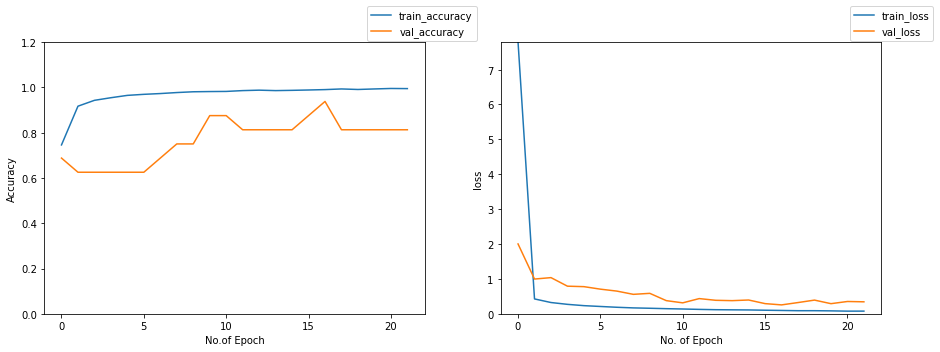

In [ ]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

AUC Score: 0.6598290598290598
              precision    recall  f1-score   support

           0       0.97      0.32      0.49       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



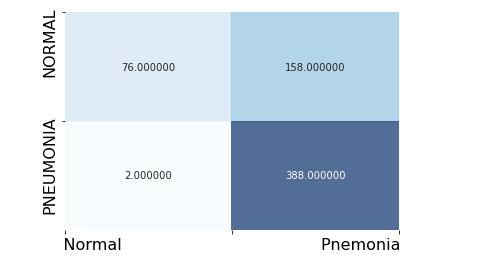

In [ ]:
fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print("AUC Score:",auc_score)


plt.figure()
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(range(2),label,fontsize= 16)
print(classification_report(test_batch.classes,pred_class))


### Inference:
1. Inspite of using Dropout regulizer, transfer learning techniques the model doesn't seem to have good F1 score because of imbalance as the pnemonia class are relatively higher in count so model is biased to pnemonia class.

2. The imbalance can be rectified by means of data augmentation techniques.

In [ ]:
## Data augmentation technique

datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
height_shift_range=0.1,shear_range=0.15, 
zoom_range=0.1,channel_shift_range = 10, horizontal_flip=True)

image_path = r'/content/drive/MyDrive/chest_xray/train/NORMAL'
save_path = r'/content/drive/MyDrive/chest_xray/train/NORMAL'

normal = len([name for name in os.listdir(r'/content/drive/MyDrive/chest_xray/train/NORMAL')])
pne = len([name for name in os.listdir(r'/content/drive/MyDrive/chest_xray/train/PNEUMONIA')])

for i in os.listdir(image_path):
    if (normal< pne):##Enter the augmentation process only  
        image = load_img(os.path.join(image_path,i))
        image = np.expand_dims(image,axis=0)
        datagen.fit(image)

                for x, val in zip(datagen.flow(image,                    #image we chose
                    save_to_dir=save_path,     #this is where we figure out where to save
                    save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
                    save_format='jpeg'),range(1)) : 
                      normal = len([name for name in os.listdir(r'/content/drive/MyDrive/chest_xray/train/NORMAL')])
                      pne = len([name for name in os.listdir(r'/content/drive/MyDrive/chest_xray/train/PNEUMONIA')])
    else:
        break

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


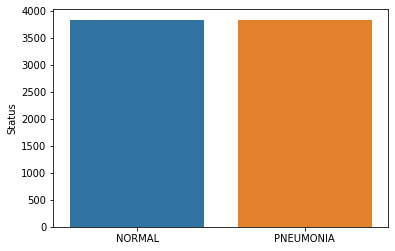

NORMAL       3835
PNEUMONIA    3827
Name: Status, dtype: int64

In [ ]:
label = ['NORMAL','PNEUMONIA']

files = [[j,k] for j in label for k in 
         os.listdir(os.path.join(r'/content/drive/MyDrive/chest_xray/train',j))]
df = pd.DataFrame(files,columns=['Status','Img_name'])
val_count = df.Status.value_counts()
sns.barplot(val_count.index,val_count)
plt.show()
val_count

###### Imbalace dataset is transformed into balanced one

In [ ]:
train_batch = datagen.flow_from_directory(directory=train_path
                                          ,batch_size = 250,target_size=image_size,shuffle =True, seed=0,
                                          classes=['NORMAL','PNEUMONIA']) ##Mini batch technique is deployed

test_batch = datagen.flow_from_directory(directory=test_path
                                          ,batch_size =16,target_size=image_size,shuffle =False
                                          ,classes=['NORMAL','PNEUMONIA'])

val_batch = datagen.flow_from_directory(directory=val_path
                                          ,batch_size = 624,target_size=image_size,shuffle =True
                                          ,classes=['NORMAL','PNEUMONIA'])
train_batch.class_indices

Found 7661 images belonging to 2 classes.
Found 626 images belonging to 2 classes.
Found 179 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
## Single layer neural network model is made as the basline model to benchmark the deep layered NN

model_baseline = Sequential([Conv2D(filters = 16 ,
                           kernel_size = (3,3),activation='relu', padding = 'valid',input_shape = (224,224,3)),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                   Flatten(),
                   Dense(units = 2,activation = 'softmax')])

model_baseline.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])   

model_baseline.summary()                

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 197136)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 394274    
Total params: 394,722
Trainable params: 394,722
Non-trainable params: 0
_________________________________________________________________


In [ ]:
r = model_baseline.fit(train_batch,
  validation_data=(val_batch),
  epochs=1,
  steps_per_epoch=len(train_batch),
  verbose=1)

31/31 [==============================] - 2164s 70s/step - loss: 1.8524 - accuracy: 0.5986 - val_loss: 0.2801 - val_accuracy: 0.9050


In [ ]:
pred = model_baseline.predict(test_batch)
pred_class = np.argmax(pred, axis=-1)

              precision    recall  f1-score   support

           0       0.53      0.94      0.68       234
           1       0.93      0.51      0.66       392

    accuracy                           0.67       626
   macro avg       0.73      0.72      0.67       626
weighted avg       0.78      0.67      0.66       626



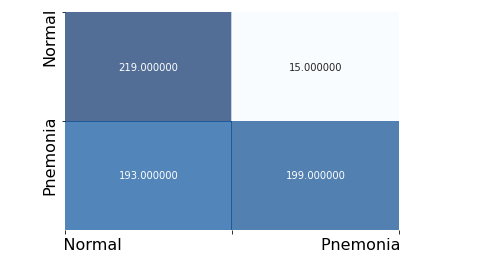

In [ ]:
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(np.arange(2),['Normal','Pnemonia' ],
           fontsize=16,rotation=90)
cr_rmsprop = classification_report(test_batch.classes,pred_class)
print(classification_report(test_batch.classes,pred_class))

In [ ]:
model = Sequential([Conv2D(filters = 16 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3),activation='relu', padding = 'valid',input_shape = (224,224,3)),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    
                   Conv2D(filters = 32 ,kernel_initializer=tf.initializers.GlorotNormal,
                          kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2),strides = 2),
                    Conv2D(filters = 64 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    Conv2D(filters = 128 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 256 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 256 ,kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(units = 512,activation = 'relu'),
                    Dense(units = 2,activation = 'softmax')])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', patience=5, 
        verbose=1, mode='min', restore_best_weights=True)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [ ]:
r = model.fit(train_batch,
  validation_data=(val_batch),
  epochs=100,
  steps_per_epoch=len(train_batch),
  callbacks=[monitor],verbose=1)

Epoch 1/100
154/154 [==============================] - 3596s 23s/step - loss: 0.3665 - accuracy: 0.8559 - val_loss: 0.8817 - val_accuracy: 0.7095
Epoch 2/100
154/154 [==============================] - 198s 1s/step - loss: 0.2928 - accuracy: 0.8905 - val_loss: 0.5457 - val_accuracy: 0.8659
Epoch 3/100
154/154 [==============================] - 195s 1s/step - loss: 0.2690 - accuracy: 0.9078 - val_loss: 0.6881 - val_accuracy: 0.8883
Epoch 4/100
154/154 [==============================] - 197s 1s/step - loss: 0.2587 - accuracy: 0.9106 - val_loss: 6.0316 - val_accuracy: 0.4916
Epoch 5/100
154/154 [==============================] - 195s 1s/step - loss: 0.2237 - accuracy: 0.9255 - val_loss: 0.2525 - val_accuracy: 0.8827
Epoch 6/100
154/154 [==============================] - 194s 1s/step - loss: 0.2024 - accuracy: 0.9308 - val_loss: 0.7387 - val_accuracy: 0.7709
Epoch 7/100
154/154 [==============================] - 195s 1s/step - loss: 0.1897 - accuracy: 0.9345 - val_loss: 0.3693 - val_accurac

In [ ]:
pred = model.predict(test_batch)
pred_class = np.argmax(pred, axis=-1)

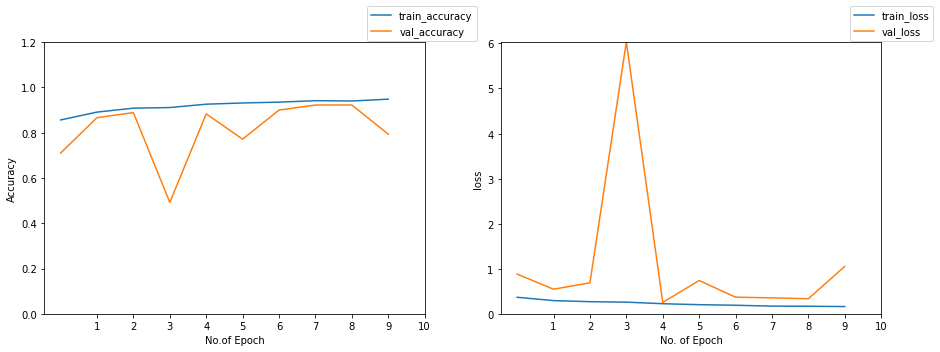

In [ ]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       234
           1       0.91      0.87      0.89       392

    accuracy                           0.87       626
   macro avg       0.86      0.87      0.86       626
weighted avg       0.87      0.87      0.87       626



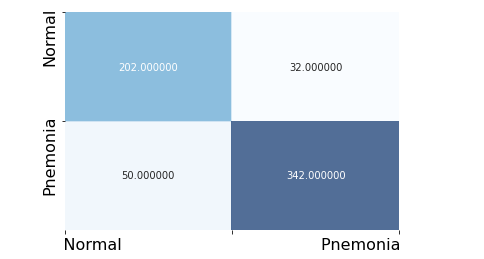

In [ ]:
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(np.arange(2),['Normal','Pnemonia' ],
           fontsize=16,rotation=90)
cr_rmsprop = classification_report(test_batch.classes,pred_class)
print(classification_report(test_batch.classes,pred_class))


0.8678484214198502


Text(0, 0.5, 'TPR')

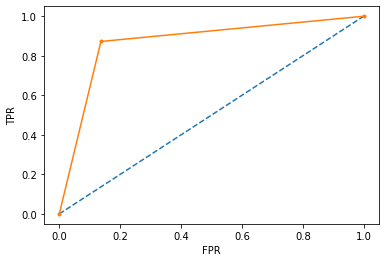

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve

fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score_rmsprop = roc_auc_score(test_batch.labels,pred_class)
print(auc_score_rmsprop)

ns_probs = [0 for _ in range(len(test_batch.labels))]
ns_auc = roc_auc_score(test_batch.labels, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(test_batch.labels, ns_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CNN')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
model_adams = Sequential([Conv2D(filters = 16 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3),activation='relu', padding = 'valid',input_shape = (224,224,3)),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                   Conv2D(filters = 32 ,kernel_initializer=tf.initializers.GlorotNormal,
                          kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2),strides = 2),
                    Conv2D(filters = 64 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    Conv2D(filters = 128 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 256 ,kernel_initializer=tf.initializers.GlorotNormal,
                           kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    #BatchNormalization(),
                    #Conv2D(filters = 256 ,kernel_size = (3,3), activation='relu', padding = 'same'),
                   #MaxPool2D(pool_size = (2,2), strides = 2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(units = 512,activation = 'relu'),
                    Dense(units = 2,activation = 'softmax')])

model_adams.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', patience=5, 
        verbose=1, mode='min', restore_best_weights=True)

In [ ]:
r = model_adams.fit(train_batch,
  validation_data=val_batch,
  epochs=100,
  steps_per_epoch=len(train_batch),
  callbacks=[monitor],verbose = 1 )

Epoch 1/100
154/154 [==============================] - 200s 1s/step - loss: 0.5010 - accuracy: 0.8616 - val_loss: 1.0108 - val_accuracy: 0.5810
Epoch 2/100
154/154 [==============================] - 195s 1s/step - loss: 0.1933 - accuracy: 0.9265 - val_loss: 0.4662 - val_accuracy: 0.8603
Epoch 3/100
154/154 [==============================] - 196s 1s/step - loss: 0.1831 - accuracy: 0.9320 - val_loss: 0.2679 - val_accuracy: 0.9050
Epoch 4/100
154/154 [==============================] - 195s 1s/step - loss: 0.1443 - accuracy: 0.9474 - val_loss: 0.7517 - val_accuracy: 0.6425
Epoch 5/100
154/154 [==============================] - 197s 1s/step - loss: 0.1468 - accuracy: 0.9464 - val_loss: 0.2829 - val_accuracy: 0.9050
Epoch 6/100
154/154 [==============================] - 200s 1s/step - loss: 0.1332 - accuracy: 0.9494 - val_loss: 0.3075 - val_accuracy: 0.9106
Epoch 7/100
154/154 [==============================] - 201s 1s/step - loss: 0.1456 - accuracy: 0.9436 - val_loss: 0.2769 - val_accuracy:

In [ ]:
pred = model.predict(test_batch)
pred_class = np.argmax(pred,axis=-1)

In [ ]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       234
           1       0.92      0.86      0.89       392

    accuracy                           0.86       626
   macro avg       0.85      0.87      0.86       626
weighted avg       0.87      0.86      0.87       626



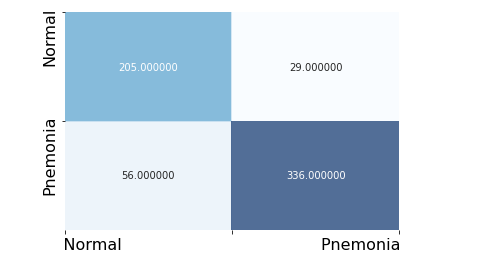

In [ ]:
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(np.arange(2),['Normal','Pnemonia' ],
           fontsize=16,rotation=90)
print(classification_report(test_batch.classes,pred_class))

cr_adam = classification_report(test_batch.classes,pred_class)

0.8666056166056166


Text(0, 0.5, 'TPR')

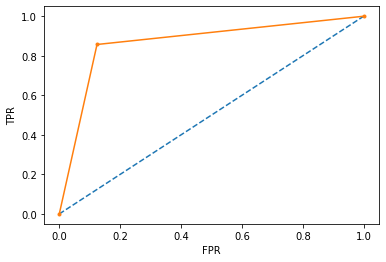

In [ ]:
fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score_adam = roc_auc_score(test_batch.labels,pred_class)
print(auc_score_adam)

ns_probs = [0 for _ in range(len(test_batch.labels))]
ns_auc = roc_auc_score(test_batch.labels, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(test_batch.labels, ns_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CNN')
plt.xlabel('FPR')
plt.ylabel('TPR')

#### Transfer learning technique

##### VVG16 Model

In [ ]:
vgg16 = tf.keras.applications.vgg16.VGG16(input_shape = image_size+[3]
                                                ,weights='imagenet'
                                                ,include_top=False)

In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model_vgg = Sequential()

for layer in vgg16.layers:
    layer.trainable =False
    model_vgg.add(layer)
    
model_vgg.add(Flatten())
model_vgg.add(Dense(units = 2,activation = 'softmax'))
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
model_vgg.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy'
              , metrics=['accuracy'])

r_vgg = model_vgg.fit(train_batch,
  validation_data=val_batch,
  epochs=100,
  steps_per_epoch=len(train_batch),
  validation_steps=len(val_batch),
            callbacks=[monitor] )

Epoch 1/100
154/154 [==============================] - 214s 1s/step - loss: 2.1685 - accuracy: 0.9259 - val_loss: 5.3708 - val_accuracy: 0.8324
Epoch 2/100
154/154 [==============================] - 202s 1s/step - loss: 1.1020 - accuracy: 0.9526 - val_loss: 2.3823 - val_accuracy: 0.9218
Epoch 3/100
154/154 [==============================] - 200s 1s/step - loss: 1.1288 - accuracy: 0.9577 - val_loss: 1.8553 - val_accuracy: 0.9665
Epoch 4/100
154/154 [==============================] - 201s 1s/step - loss: 1.1451 - accuracy: 0.9619 - val_loss: 0.9023 - val_accuracy: 0.9553
Epoch 5/100
154/154 [==============================] - 201s 1s/step - loss: 1.1396 - accuracy: 0.9633 - val_loss: 2.4499 - val_accuracy: 0.9665
Epoch 6/100
154/154 [==============================] - 200s 1s/step - loss: 1.1772 - accuracy: 0.9628 - val_loss: 2.0537 - val_accuracy: 0.9609
Epoch 7/100
154/154 [==============================] - 201s 1s/step - loss: 0.9500 - accuracy: 0.9697 - val_loss: 0.6861 - val_accuracy:

In [ ]:
pred = model_vgg.predict(test_batch)
pred_class = model_vgg.predict_classes(test_batch)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


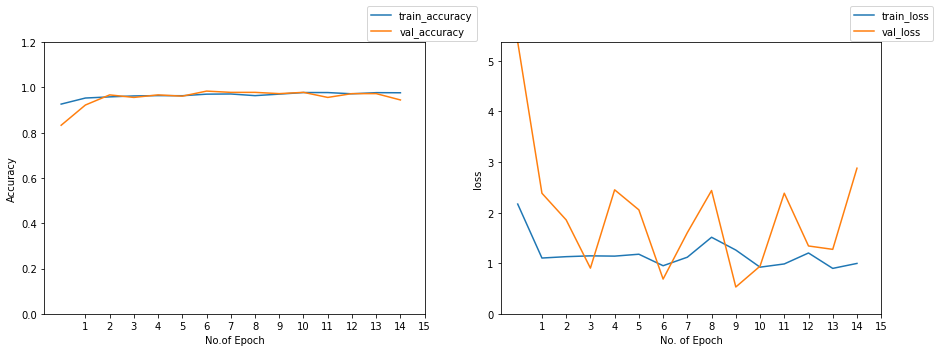

In [ ]:
train_loss = r_vgg.history['loss']
val_loss = r_vgg.history['val_loss']
train_accuracy = r_vgg.history['accuracy']
val_accuracy = r_vgg.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

AUC Score: 0.8094147915576487
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       234
           1       0.82      0.99      0.90       392

    accuracy                           0.86       626
   macro avg       0.90      0.81      0.83       626
weighted avg       0.88      0.86      0.85       626



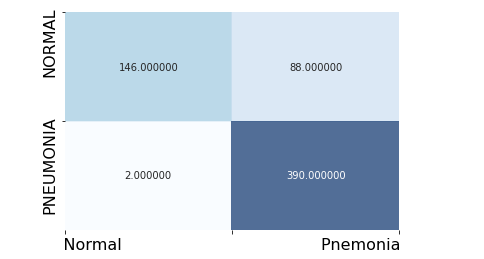

In [ ]:
fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print("AUC Score:",auc_score)
auc_score_vgg = roc_auc_score(test_batch.labels,pred_class)

plt.figure()
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(range(2),label,fontsize= 16)

cr_vgg = classification_report(test_batch.classes,pred_class)
print(classification_report(test_batch.classes,pred_class))


Text(0, 0.5, 'TPR')

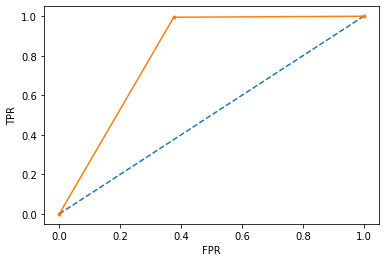

In [ ]:
ns_probs = [0 for _ in range(len(test_batch.labels))]
ns_auc = roc_auc_score(test_batch.labels, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(test_batch.labels, ns_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CNN')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
resnet = tf.keras.applications.ResNet50(input_shape = image_size+[3],
                                        weights='imagenet',
                                        include_top=False)
resnet.summary()

94773248/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

##### Resnet_50 model

In [ ]:
resnet = tf.keras.applications.ResNet50(input_shape = image_size+[3],
                                        weights='imagenet',
                                        include_top=False)
resnet.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
for layer in resnet.layers:
    layer.trainable = False
x = Flatten()(resnet.output)
x = Dropout(0.5)(x)
x = Dense(units = 128 , activation ='softmax')(x)
x = Dropout(0.5)(x)
x = Dense(units = 64 , activation ='softmax')(x)
x = Dropout(0.5)(x)
x = Dense(units = 32 , activation ='softmax')(x)
x = Dense(units = 2 , activation ='softmax')(x)
output = Dense(units = 2 , activation ='softmax')(x)
model_res = Model(inputs=resnet.input , outputs= output)

model_res.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
model_res.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy'
              , metrics=['accuracy'])

In [ ]:
r = model_res.fit(train_batch,
  validation_data=val_batch,
  epochs=20,
  steps_per_epoch=len(train_batch),
  callbacks=[monitor])

Epoch 1/20
154/154 [==============================] - 203s 1s/step - loss: 2.3637 - accuracy: 0.9296 - val_loss: 1.7632 - val_accuracy: 0.9441
Epoch 2/20
154/154 [==============================] - 198s 1s/step - loss: 1.7863 - accuracy: 0.9492 - val_loss: 1.4932 - val_accuracy: 0.9553
Epoch 3/20
154/154 [==============================] - 201s 1s/step - loss: 1.6521 - accuracy: 0.9542 - val_loss: 1.1496 - val_accuracy: 0.9609
Epoch 4/20
154/154 [==============================] - 201s 1s/step - loss: 1.6365 - accuracy: 0.9577 - val_loss: 1.2214 - val_accuracy: 0.9609
Epoch 5/20
154/154 [==============================] - 201s 1s/step - loss: 1.3036 - accuracy: 0.9636 - val_loss: 2.5623 - val_accuracy: 0.9330
Epoch 6/20
154/154 [==============================] - 200s 1s/step - loss: 1.2169 - accuracy: 0.9645 - val_loss: 1.6813 - val_accuracy: 0.9553
Epoch 7/20
154/154 [==============================] - 201s 1s/step - loss: 1.3520 - accuracy: 0.9684 - val_loss: 2.5755 - val_accuracy: 0.9218

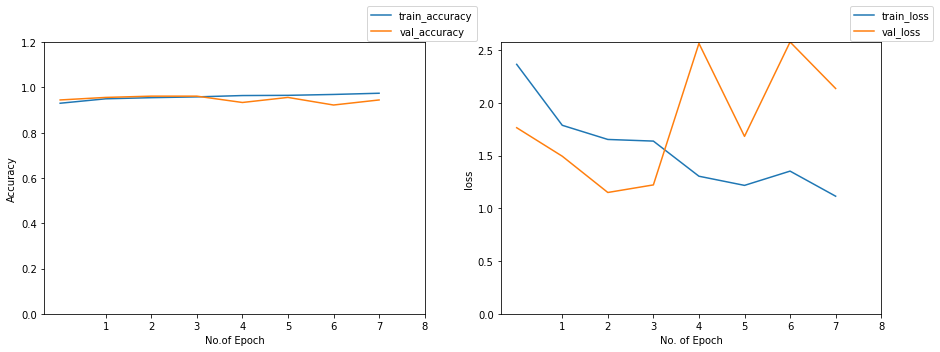

In [ ]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

In [ ]:
pred = model_mobilnet.predict(test_batch)
pred_class = pred.argmax(axis=-1)

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       234
         1.0       0.96      0.98      0.97       392

    accuracy                           0.96       626
   macro avg       0.97      0.96      0.96       626
weighted avg       0.96      0.96      0.96       626



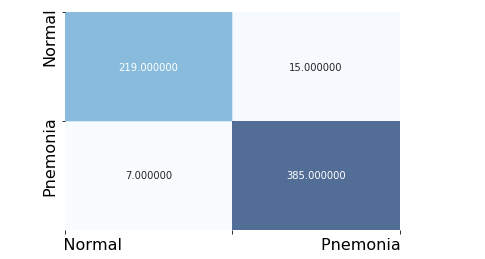

In [ ]:
fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score_res = roc_auc_score(test_batch.labels,pred_class)



plt.figure()
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(range(2),label,fontsize= 16)

cr_res = classification_report(test_batch.classes,pred_class)
print(classification_report(test_batch.classes,pred_class))

AUC-ROC CURVE 0.9590201465201466


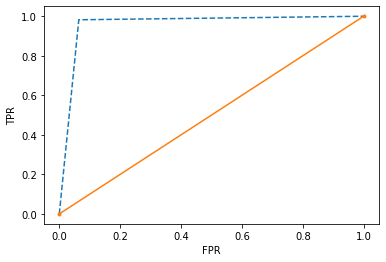

In [ ]:
ns_probs = [0 for _ in range(len(actual))]
ns_auc = roc_auc_score(actual,pred)
ns_fpr, ns_tpr, _ = roc_curve(actual,pred)
fpr, tpr, _ = roc_curve(actual,ns_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CNN')
plt.xlabel('FPR')
plt.ylabel('TPR')
print("AUC-ROC CURVE",roc_auc_score(actual,pred))

## Finally we made the final model with best accuracy, recall , precision , F1 score